# **TODO:**

## optional:
* use `random_search`
* load all dataset, then use `train test split` for splitting dataset.
* automatic data train multiplier with data augmentation

**Origin Ref**

Code: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

**Save and Load Model Ref**


Code: https://www.youtube.com/watch?v=g6kQl_EFn84&ab_channel=AladdinPersson

**SPLIT IMAGE FOLDER**

Code: https://colab.research.google.com/drive/1yor3Yq8hpXKaeDVOHDDKDVztrso2kOMx?authuser=1#scrollTo=POIt-ccfc4ud

#Import dependencies + Mount Drive

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
import time
import os
from os.path import exists
import copy

from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

cudnn.benchmark = True
plt.ion()   # interactive mode

# hubungkan dengan penyimpanan google drive
from google.colab import drive
drive.mount('/content/drive')

# cek working directory
%cd /content/drive
!pwd

Mounted at /content/drive
/content/drive
/content/drive


# Image Check

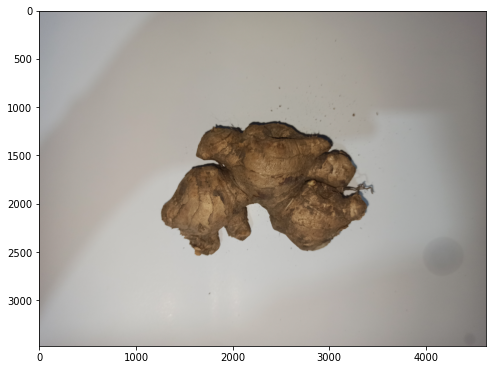

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import figure

figure(figsize=(8,8))

img = mpimg.imread('/content/drive/MyDrive/empon_data_set/empon_data_set_splitted/train/jahe_putih/1631611073520.jpg')
plt.imshow(img)

In [ ]:
from PIL import Image

# Read the input image
img = Image.open('/content/drive/MyDrive/empon_data_set/empon_data_set_splitted/train/jahe_putih/1631611073520.jpg')

# Define transform to convert the image to PyTorch Tensor
transform = transforms.ToTensor()

# Convert image to PyTorch Tensor (Image Tensor)
imgTensor = transform(img)
print("Shape of Image Tensor:\n", imgTensor.shape)

Shape of Image Tensor:
 torch.Size([3, 3472, 4624])


In [ ]:
img.show('test')

In [ ]:
imgTensor

tensor([[[0.5804, 0.5686, 0.6118,  ..., 0.4275, 0.4314, 0.4627],
         [0.5882, 0.5843, 0.6000,  ..., 0.4314, 0.4431, 0.4549],
         [0.5922, 0.5961, 0.5882,  ..., 0.4314, 0.4471, 0.4471],
         ...,
         [0.6275, 0.6392, 0.6431,  ..., 0.4667, 0.4667, 0.4980],
         [0.6275, 0.6314, 0.6314,  ..., 0.4824, 0.4549, 0.4745],
         [0.6353, 0.6235, 0.6235,  ..., 0.4941, 0.4627, 0.4863]],

        [[0.5765, 0.5647, 0.6078,  ..., 0.3922, 0.3961, 0.4275],
         [0.5843, 0.5804, 0.5961,  ..., 0.3961, 0.4078, 0.4196],
         [0.5882, 0.5922, 0.5843,  ..., 0.3961, 0.4118, 0.4118],
         ...,
         [0.6196, 0.6314, 0.6353,  ..., 0.4314, 0.4314, 0.4627],
         [0.6196, 0.6235, 0.6235,  ..., 0.4471, 0.4157, 0.4353],
         [0.6275, 0.6157, 0.6157,  ..., 0.4549, 0.4235, 0.4471]],

        [[0.5961, 0.5843, 0.6275,  ..., 0.4039, 0.4078, 0.4392],
         [0.6039, 0.6000, 0.6157,  ..., 0.4078, 0.4196, 0.4314],
         [0.6078, 0.6118, 0.6039,  ..., 0.4078, 0.4235, 0.

In [ ]:
# Compute mean of the Image Tensor across image channels RGB
R_mean, G_mean ,B_mean = torch.mean(imgTensor, dim = [1,2])
print("Mean across Red channel:", R_mean)
print("Mean across Green channel:", G_mean)
print("Mean across Blue channel:", B_mean)
print(R_mean.size())

Mean across Red channel: tensor(0.6418)
Mean across Green channel: tensor(0.6182)
Mean across Blue channel: tensor(0.5899)
torch.Size([])


In [ ]:
all_mean = torch.mean(torch.stack((R_mean, G_mean ,B_mean)))
print(all_mean)
print(all_mean.shape)

tensor(0.6166)
torch.Size([])


#Preprocessing

Data transform, directory for train-val dataset, and classes

['jahe_emprit', 'jahe_merah', 'jahe_putih', 'kencur', 'kunyit_hitam', 'kunyit_kuning', 'kunyit_putih', 'lengkuas', 'temulawak']


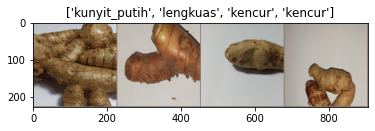

In [ ]:
# datatransform will introduce more variability to the train data
input_size = 256
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'MyDrive/empon_data_set/empon_data_set_splitted'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(class_names)


def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Functions

## Load Model

In [ ]:
def load_model(model_name, model):
    file_exists = exists('/content/drive/MyDrive/Kuliah/Semester 6/Research Methodology/Peer Review/TA_160418081/saved_models/{}.pth'.format(model_name))
    if file_exists:
        print('=> loading model')
        checkpoint = torch.load('/content/drive/MyDrive/Kuliah/Semester 6/Research Methodology/Peer Review/TA_160418081/saved_models/{}.pth'.format(model_name))
        model.load_state_dict(checkpoint['state_dict'])
        print('model {}.pth loaded \n - best accuracy {} \n - epoch {} \n'.format(model_name, checkpoint['best_accuracy'], checkpoint['current_epoch']))
    else:
        checkpoint = {}
    return (model, checkpoint)

## Train Model

try adding graph  
src: https://discuss.pytorch.org/t/how-to-plot-train-and-validation-accuracy-graph/105524

In [ ]:
def train_model(model_name, model, criterion, optimizer, scheduler, checkpoint={}, num_epochs=25):
    since = time.time()
    
    has_checkpoint = checkpoint != {}
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = checkpoint['best_accuracy'] if has_checkpoint else 0.0

    start_epoch = checkpoint['current_epoch'] + 1 if has_checkpoint else 1
    end_epoch = start_epoch + num_epochs - 1 if has_checkpoint else num_epochs

    val_losses = []
    train_losses = []
    val_accuracy = []
    train_accuracy = []
    for epoch in range(start_epoch, end_epoch + 1):
        print('Epoch {}/{}'.format(epoch, end_epoch))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                ''' zero the parameter gradients 
                explanation: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch '''
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                scheduler.step()
                train_losses.append(epoch_loss)
                train_accuracy.append(epoch_acc.cpu())

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val':
                val_losses.append(epoch_loss)
                val_accuracy.append(epoch_acc.cpu())

                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

                    # save model parameter (state_dict)
                    checkpoint = {'state_dict': model.state_dict(), 'best_accuracy': best_acc, 'current_epoch': epoch}
                    print('=> saving model')
                    torch.save(checkpoint, '/content/drive/MyDrive/Kuliah/Semester 6/Research Methodology/Peer Review/TA_160418081/saved_models/{}.pth'.format(model_name))
                    print('model {}.pth saved!'.format(model_name))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # graph loss
    plt.figure(figsize=(10,5))
    plt.title("Training and Validation Loss")
    plt.plot(val_losses, label="val")
    plt.plot(train_losses,label="train")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # graph accuracy
    plt.figure(figsize=(10,5))
    plt.title("Training and Validation Accuracy")
    plt.plot(val_accuracy, label="val")
    plt.plot(train_accuracy,label="train")
    plt.xlabel("iterations")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

backup

In [ ]:
# def train_model(model_name, model, criterion, optimizer, scheduler, checkpoint={}, num_epochs=25):
#     since = time.time()
    
#     has_checkpoint = checkpoint != {}
    
#     best_model_wts = copy.deepcopy(model.state_dict())
#     best_acc = checkpoint['best_accuracy'] if has_checkpoint else 0.0

#     start_epoch = checkpoint['current_epoch'] + 1 if has_checkpoint else 1
#     end_epoch = start_epoch + num_epochs - 1 if has_checkpoint else num_epochs
#     for epoch in range(start_epoch, end_epoch + 1):
#         print('Epoch {}/{}'.format(epoch, end_epoch))
#         print('-' * 10)

#         # Each epoch has a training and validation phase
#         for phase in ['train', 'val']:
#             if phase == 'train':
#                 model.train()  # Set model to training mode
#             else:
#                 model.eval()   # Set model to evaluate mode

#             running_loss = 0.0
#             running_corrects = 0

#             # Iterate over data.
#             for inputs, labels in dataloaders[phase]:
#                 inputs = inputs.to(device)
#                 labels = labels.to(device)

#                 ''' zero the parameter gradients 
#                 explanation: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch '''
#                 optimizer.zero_grad()

#                 # forward
#                 # track history if only in train
#                 with torch.set_grad_enabled(phase == 'train'):
#                     outputs = model(inputs)
#                     _, preds = torch.max(outputs, 1)
#                     loss = criterion(outputs, labels)

#                     # backward + optimize only if in training phase
#                     if phase == 'train':
#                         optimizer.zero_grad()
#                         loss.backward()
#                         optimizer.step()

#                 # statistics
#                 running_loss += loss.item() * inputs.size(0)
#                 running_corrects += torch.sum(preds == labels.data)

#             if phase == 'train':
#                 scheduler.step()

#             epoch_loss = running_loss / dataset_sizes[phase]
#             epoch_acc = running_corrects.double() / dataset_sizes[phase]

#             print('{} Loss: {:.4f} Acc: {:.4f}'.format(
#                 phase, epoch_loss, epoch_acc))

#             # deep copy the model
#             if phase == 'val' and epoch_acc > best_acc:
#                 best_acc = epoch_acc
#                 best_model_wts = copy.deepcopy(model.state_dict())

#                 # save model parameter (state_dict)
#                 checkpoint = {'state_dict': model.state_dict(), 'best_accuracy': best_acc, 'current_epoch': epoch}
#                 print('=> saving model')
#                 torch.save(checkpoint, '/content/drive/MyDrive/Kuliah/Semester 6/Research Methodology/Peer Review/TA_160418081/saved_models/{}.pth'.format(model_name))
#                 print('model {}.pth saved!'.format(model_name))

#         print()

#     time_elapsed = time.time() - since
#     print('Training complete in {:.0f}m {:.0f}s'.format(
#         time_elapsed // 60, time_elapsed % 60))
#     print('Best val Acc: {:4f}'.format(best_acc))

#     # load best model weights
#     model.load_state_dict(best_model_wts)
#     return model

## Visualize Model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}\nactual: {}'.format(class_names[preds[j]], [class_names[x] for x in labels][j]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Test Model

Source code: https://deeplizard.com/learn/video/0LhiS6yu2qQ

In [ ]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()
    
def test_model(model):
    was_training = model.training
    model.eval()

    all_preds = torch.tensor([]).to(device)
    test_set_targets = torch.tensor([]).to(device)

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            preds = model(inputs)
            all_preds = torch.cat(
                (all_preds, preds)
                ,dim=0
            )
            test_set_targets = torch.cat(
                (test_set_targets, labels)
                ,dim=0
            )

        model.train(mode=was_training)

        prediction_loader = torch.utils.data.DataLoader(dataloaders['test'], batch_size=4)
        test_preds = all_preds

    preds_correct = get_num_correct(test_preds, test_set_targets)

    print('total correct:', preds_correct)
    print('accuracy:', preds_correct / len(test_set_targets))

    cm = confusion_matrix(test_set_targets.cpu(), test_preds.cpu().argmax(dim=1))
    return cm

## Confusion Matrix Plot

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Training

## Check/Load Model

In [ ]:
pretrained_model = 'mobilenet_v3_large'
model_name = '{}-{}-all-c9'.format(pretrained_model, input_size)

# use gpu if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = models.mobilenet_v3_large(pretrained=True)

'''vgg16/mobilenet_v3_large settings'''
# num_ftrs = model.classifier[6].in_features
# model.classifier[6] = nn.Linear(num_ftrs, len(class_names))
num_ftrs = model.classifier[3].in_features
model.classifier[3] = nn.Linear(num_ftrs, len(class_names))

'''shufflenet_v2_x1_0 settings'''
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, len(class_names))

# load model
cp = {}
# (model, cp) = load_model(model_name, model)

# # change 8192 size
# model.conv5[0]=nn.Conv2d(464, 8192, kernel_size=(1, 1), stride=(1, 1), bias=False)
# model.conv5[1]=nn.BatchNorm2d(8192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

model = model.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth


  0%|          | 0.00/21.1M [00:00<?, ?B/s]

## Saving Full Model

In [ ]:
torch.save(model_conv, '/content/drive/MyDrive/Kuliah/Semester 6/Research Methodology/Peer Review/TA_160418081/saved_models/empon_mobilenet_v3_large_c9.pth')

## Loading Full Model

In [ ]:
# Model class must be defined somewhere
model = torch.load('/content/drive/MyDrive/Kuliah/Semester 6/Research Methodology/Peer Review/TA_160418081/saved_models/empon_vgg16.pth')
model.eval()

In [ ]:
print(model)
# summary(model, (3, input_size, input_size))

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

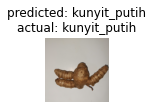

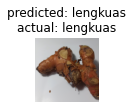

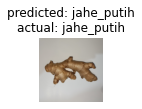

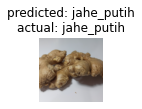

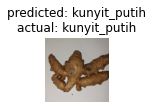

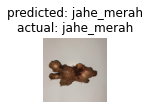

In [ ]:
visualize_model(model)

##Training all layer

Epoch 1/12
----------
train Loss: 1.4202 Acc: 0.4923
val Loss: 0.3807 Acc: 0.8789
=> saving model
model vgg16-256-all-c9.pth saved!

Epoch 2/12
----------
train Loss: 0.6691 Acc: 0.7609
val Loss: 0.2569 Acc: 0.9148
=> saving model
model vgg16-256-all-c9.pth saved!

Epoch 3/12
----------
train Loss: 0.5201 Acc: 0.8115
val Loss: 0.1858 Acc: 0.9283
=> saving model
model vgg16-256-all-c9.pth saved!

Epoch 4/12
----------
train Loss: 0.3918 Acc: 0.8704
val Loss: 0.1636 Acc: 0.9462
=> saving model
model vgg16-256-all-c9.pth saved!

Epoch 5/12
----------
train Loss: 0.3924 Acc: 0.8693
val Loss: 0.1747 Acc: 0.9193

Epoch 6/12
----------
train Loss: 0.3068 Acc: 0.8963
val Loss: 0.0594 Acc: 0.9686
=> saving model
model vgg16-256-all-c9.pth saved!

Epoch 7/12
----------
train Loss: 0.2473 Acc: 0.9117
val Loss: 0.2506 Acc: 0.9013

Epoch 8/12
----------
train Loss: 0.1957 Acc: 0.9340
val Loss: 0.0702 Acc: 0.9731
=> saving model
model vgg16-256-all-c9.pth saved!

Epoch 9/12
----------
train Loss: 0.

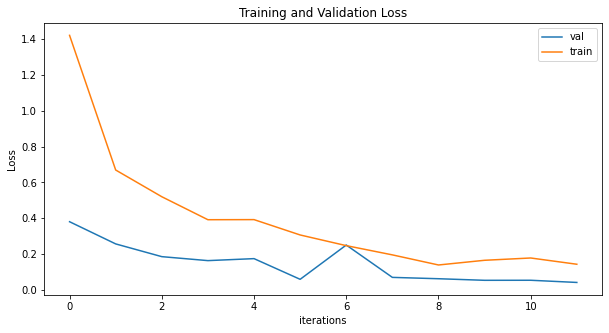

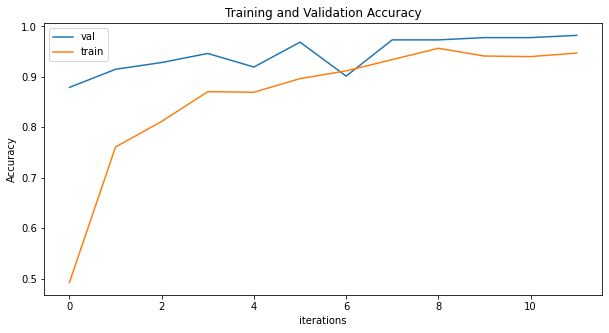

In [ ]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001)

''' StepLR Decays the learning rate of each parameter group by gamma 
every step_size epochs.
Decay LR by a factor of 0.1 every 7 epochs.
Learning rate scheduling should be applied after optimizer’s update.

e.g., you should write your code this way:
for epoch in range(100):
    train(...)
    validate(...)
    scheduler.step() '''

step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model_name, model, criterion, optimizer, step_lr_scheduler, checkpoint=cp, num_epochs=12)

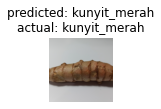

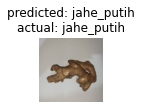

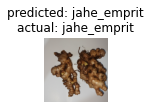

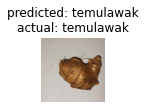

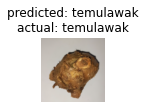

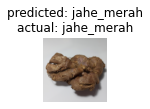

In [ ]:
visualize_model(model)

## Check/Load Model

In [ ]:
pretrained_model = 'mobilenet_v3_large'
model_conv_name = '{}-{}-last-c9'.format(pretrained_model, input_size)

''' Here, we need to freeze all the network except the final layer.
We need to set requires_grad == False to freeze the parameters so that 
the gradients are not computed in backward() '''

'''Parameters of newly constructed modules have requires_grad=True by default'''
model_conv = models.mobilenet_v3_large(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

'''vgg16/mobilenet_v3_large settings'''
# num_ftrs = model_conv.classifier[6].in_features
# model_conv.classifier[6] = nn.Linear(num_ftrs, len(class_names))
num_ftrs = model.classifier[3].in_features
model_conv.classifier[3] = nn.Linear(num_ftrs, len(class_names))

'''shufflenet_v2_x1_0 settings'''
# num_ftrs = model_conv.fc.in_features
# model_conv.fc = nn.Linear(num_ftrs, len(class_names))

'''load model'''
cp_conv = {}
# (model_conv, cp_conv) = load_model(model_conv_name, model_conv)

model_conv = model_conv.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# print(model_conv)
summary(model_conv, (3, input_size, input_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 128, 128]             648
       BatchNorm2d-2         [-1, 24, 128, 128]              48
              ReLU-3         [-1, 24, 128, 128]               0
         MaxPool2d-4           [-1, 24, 64, 64]               0
            Conv2d-5           [-1, 24, 32, 32]             216
       BatchNorm2d-6           [-1, 24, 32, 32]              48
            Conv2d-7           [-1, 58, 32, 32]           1,392
       BatchNorm2d-8           [-1, 58, 32, 32]             116
              ReLU-9           [-1, 58, 32, 32]               0
           Conv2d-10           [-1, 58, 64, 64]           1,392
      BatchNorm2d-11           [-1, 58, 64, 64]             116
             ReLU-12           [-1, 58, 64, 64]               0
           Conv2d-13           [-1, 58, 32, 32]             522
      BatchNorm2d-14           [-1, 58,

##Training only last layer

Epoch 1/12
----------
train Loss: 1.6636 Acc: 0.4853
val Loss: 0.7759 Acc: 0.8610
=> saving model
model mobilenet_v3_large-256-last-c9.pth saved!

Epoch 2/12
----------
train Loss: 1.1437 Acc: 0.6761
val Loss: 0.4736 Acc: 0.9148
=> saving model
model mobilenet_v3_large-256-last-c9.pth saved!

Epoch 3/12
----------
train Loss: 0.9908 Acc: 0.7067
val Loss: 0.3748 Acc: 0.9372
=> saving model
model mobilenet_v3_large-256-last-c9.pth saved!

Epoch 4/12
----------
train Loss: 0.8990 Acc: 0.7161
val Loss: 0.3160 Acc: 0.9372

Epoch 5/12
----------
train Loss: 0.8528 Acc: 0.7138
val Loss: 0.2942 Acc: 0.9372

Epoch 6/12
----------
train Loss: 0.8342 Acc: 0.7362
val Loss: 0.2629 Acc: 0.9372

Epoch 7/12
----------
train Loss: 0.7454 Acc: 0.7515
val Loss: 0.2443 Acc: 0.9507
=> saving model
model mobilenet_v3_large-256-last-c9.pth saved!

Epoch 8/12
----------
train Loss: 0.7590 Acc: 0.7644
val Loss: 0.2381 Acc: 0.9507

Epoch 9/12
----------
train Loss: 0.8128 Acc: 0.7385
val Loss: 0.2418 Acc: 0.946

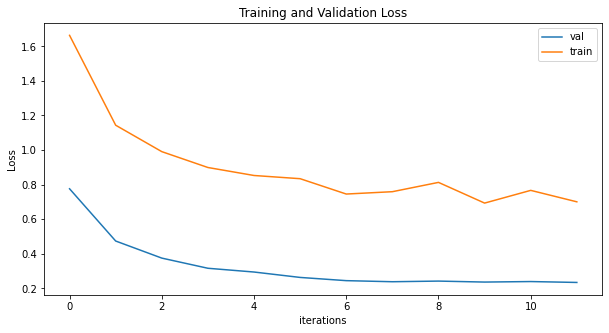

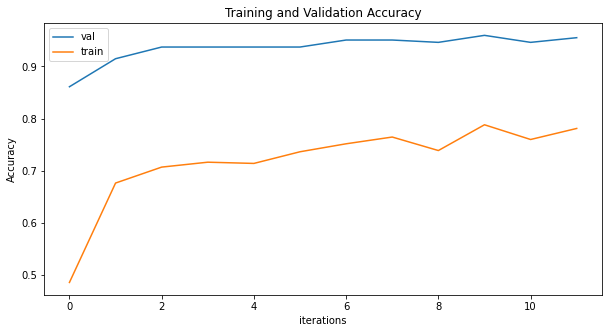

In [ ]:
#### ConvNet as fixed feature extractor ####

criterion = nn.CrossEntropyLoss()

''' Observe that only parameters of final layer are being optimized 
as opposed to before. '''
# optimizer_conv = optim.SGD(model_conv.classifier.parameters(), lr=0.001, momentum=0.9)
optimizer_conv = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv_name, model_conv, criterion, optimizer_conv,
                          exp_lr_scheduler, checkpoint=cp_conv, num_epochs=12)

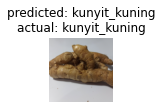

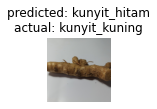

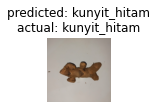

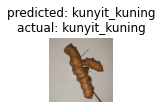

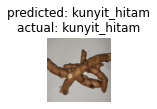

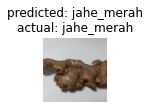

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

# Testing + Confusion Matrix

In [ ]:
cm = test_model(model)

total correct: 59
accuracy: 0.9516129032258065


Confusion matrix, without normalization
[[4 0 1 0 0 0 0 0 1]
 [0 7 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0]
 [0 0 0 7 0 0 0 0 0]
 [0 0 0 0 7 0 0 0 0]
 [0 0 0 0 0 6 1 0 0]
 [0 0 0 0 0 0 7 0 0]
 [0 0 0 0 0 0 0 7 0]
 [0 0 0 0 0 0 0 0 7]]


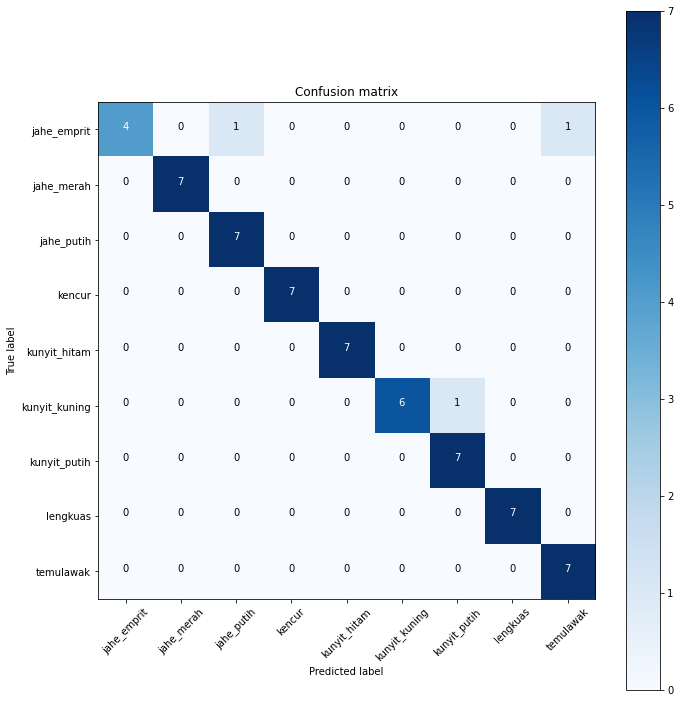

In [ ]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, class_names)